In [1]:
# Imports
import torch
cuda = torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append("../../semi-supervised")

# β-Variational Autoencoder

The β-VAE as proposed by [Higgins et al.]() is a relatively simple adjustment to the standard VAE training framework in which we alter the loss function as to scale the KL-divergence by a constant $\beta$. This simple change allows the VAE to create a highly disentangled representation of the data distribution. Typically, we will see that for a $\beta$-VAE the principal directions of the latent distribution encode disjoint properties of the distribution, such as scale, location, rotation etc. We will see examples of this later.

Their hypothesis is that we can rewrite objective as a constrained optimization problem in which we wish to maximize the log generative distribution subject to the constraint that the variational distribution over $z$ should be very similar to the prior in the KL-divergence sense.

$$\mathbb{E}_{q_{\phi}(z|x)[\log p_{\theta}(x|z)]}  \text{ subject to }  D_{KL}(q_{\phi}(z|x)||p(z)) < \epsilon$$

Of which the Langrange multiplier $\beta$ naturally arises, such that for $\beta > 1$ we can compute the lower bound on the data.

$$\mathcal{L}(\phi, \theta; x, z, \beta) = \mathbb{E}_{q_{\phi}(z|x)[\log p_{\theta}(x|z)]}  -  \beta D_{KL}(q_{\phi}(z|x)||p(z))$$

This constraint forces the variational distribution to maximize independence across axes in order to ensure as much information is contained in $z$. We shall also see that a disentangled representation does not neccesarily produce good samples, because the latent space is essentially under limited expressive power.

## Dataset

For this experiment, we will not use MNIST, as it is somewhat difficult to qualitatively measure the degree of disentanglement on this dataset. Instead we will use the accompanying dataset for the $\beta$-VAE paper, which is the [dSprite dataset](https://github.com/deepmind/dsprites-dataset) by Deepmind. The dataset features a number of images of shapes under different geometrical transform such as:

* Color
* Scale
* Orientation
* X-position
* Y-position

all of which the $\beta$-VAE should be able to disentangle.

In [42]:
from datautils import SpriteDataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

dset = SpriteDataset(transform=lambda x: x.reshape(-1))

# We will just use the first 245760 samples, which are equivalent to keeping the shape constant
train = DataLoader(dset, batch_size=16, sampler=SubsetRandomSampler(indices=np.arange(len(dset)//3)))

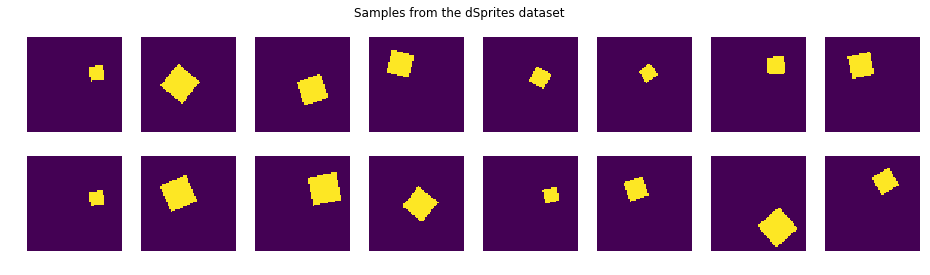

In [3]:
f, axarr = plt.subplots(2, 8, figsize=(16, 4))

samples = next(iter(train))

for i, ax in enumerate(axarr.flat):
    ax.imshow(samples[i].view(64, 64).numpy())
    ax.axis("off")
    
plt.suptitle("Samples from the dSprites dataset")
plt.show()

The model is by default completely unchanged. However, we want to recreate the results from the paper, for which we will need a custom VAE that has different activations in the encoder and decoder respectively.

In [4]:
import torch.nn as nn
from models import VariationalAutoencoder

model = VariationalAutoencoder([64**2, 10, [1200, 1200]])

# Decoder as described in the paper
model.decoder = nn.Sequential(
    nn.Linear(10, 1200),
    nn.Tanh(),
    nn.Linear(1200, 1200),
    nn.Tanh(),
    nn.Linear(1200, 1200),
    nn.Tanh(),
    nn.Linear(1200, 64**2),
    nn.Sigmoid(),
)

model

VariationalAutoencoder(
  (encoder): Encoder(
    (hidden): ModuleList(
      (0): Linear(in_features=4096, out_features=1200)
      (1): Linear(in_features=1200, out_features=1200)
    )
    (sample): GaussianSample(
      (mu): Linear(in_features=1200, out_features=10)
      (log_var): Linear(in_features=1200, out_features=10)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096)
    (7): Sigmoid()
  )
)

## Training

In the training loop we simple alter the already present $\beta$ value to the desired value. In this example we use an iterator as to ensure compatability with the SVI interface, but a number would suffice. The paper recommends $\beta_{norm} = \beta \frac{M}{N}$, where $M, N$ are dimensions of the latent space and input space respectively.

In [5]:
from itertools import repeat

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

# This is the β-VAE
beta = repeat(4.0)

In [9]:
from torch.autograd import Variable

for epoch in range(251):
    model.train()
    total_loss = 0
    for u in train:
        u = Variable(u.float())

        if cuda: u = u.cuda(device=0)

        reconstruction = model(u)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
        elbo = likelihood - next(beta) * model.kl_divergence
        
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data[0]

    m = len(train)

    if epoch % 1 == 0:
        print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}")

## Disentangled samples

Below we show how the $\beta$-VAE has learned a disentangled representation by perturbing $z$ in each of its principal directions. First we choose a specific sample from the data as seen below. We then use the encoder to transfer into the latent space. From here we can translate the sample in each direction to see what each coordinate direction encodes.

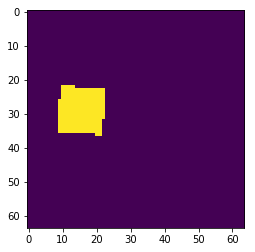

In [143]:
x, *_ = next(iter(train))
plt.imshow(x.numpy().reshape(64, 64))
plt.show()

In [208]:
# Above image encoded to z
z, _, _ = model.encoder(Variable(x.float()))
z = z.repeat(10, 1)

# Perturb the first dimension of the first element
# the second dimension of the second element, etc.
for i in range(1, 10):
    z[i, i-1] += 10

samples = model.sample(z)

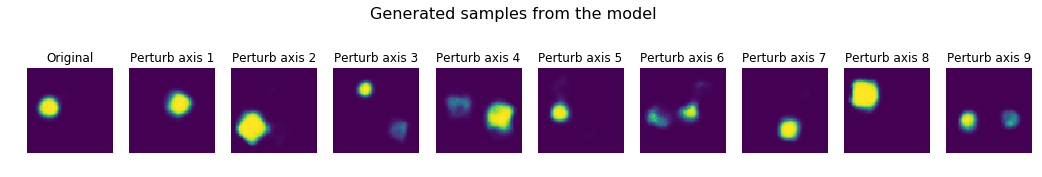

In [220]:
f, axarr = plt.subplots(1, 10, figsize=(18, 3))

for i, ax in enumerate(axarr.flat):
    ax.set_title("Perturb axis {}".format(i))
    if i == 0:
        ax.set_title("Original")
    ax.imshow(samples[i].view(64, 64).data.numpy())
    ax.axis("off")
    
plt.suptitle("Generated samples from the model", fontsize=16)
plt.show()

As we can see the representation is not totally disentangled, but each direction seem to represent some aspect of the data. Examples:

* The first direction encodes translation along the $x$-axis.
* The second direction encodes translation along the $y$-axis, but also rotation and shape.
* The third direction encodes scale along with translation.
* The eight direction encodes shape.

The samples above are from a model trained for approximately 200 epochs. Naturally, one would expect better results through a longer training period, but the size of the dataset makes it computationally prohibitive.

## Semi-supervised context

The $\beta$ parameter has been implemented directly in the `SVI` function. Please note that at the moment there is a conflict in the usage of this term. The advanced VAE-based models, such as LVAE and ADGM rely on this parameter in the context of temperature. The temperature is critical to warm-up the stochastic units as to make sure that they stay activated throughout training, setting $\beta$ constant or greater than one is likely to fail.

Therefore, at the moment it seems that the $\beta$-VAE framework is incompatible with these models.

***However, you can still attempt it by changing the following line in the other notebooks***

In [ ]:
from itertools import repeat
elbo = SVI(model, likelihood=binary_cross_entropy, sampler=sampler, beta=repeat(4.0)) # Or your choice of beta value